# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


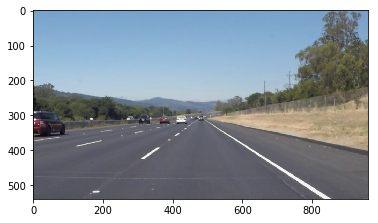

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math


def grayscale(image):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    # return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
slope_right = np.nan
slope_left = np.nan
b_right = np.nan
b_left = np.nan

def getX(y1, y2, m, b):
    '''
    Helper function to calculate x1 and x2 based on y1, y2, slope (m) and constant(b)
    '''
    return int((y1 - b)/m), int((y2 - b)/m)

g_s_right = np.zeros(5)
def getSlope(s_right):
    '''
    Helper function to compare output.
    The right lane has an average slope from the previous 5 frames
    '''
    global g_s_right
    if g_s_right.mean() == 0:
        g_s_right.fill(s_right)
    else:
        g_s_right = np.append(g_s_right[1:], s_right)
    return g_s_right.mean()

g_b_right = np.zeros(5)
def getB(b_r):
    '''
    Helper function to compare output.
    The right lane has an average constant from the previous 5 frames
    '''
    global g_b_right
    if g_b_right.mean() == 0:
        g_b_right.fill(b_r)
    else:
        g_b_right = np.append(g_b_right[1:], b_r)
    return g_b_right.mean()

def draw_lines(img, lines, single_img=False, debug=False, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global slope_left
    global slope_right
    global b_left
    global b_right

    slopes_left = np.array([slope_left])
    slopes_right = np.array([slope_right])
    bs_right = np.array([b_right])
    bs_left = np.array([b_left])
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            threshold_slope = 0.5
            # Filter out horizontal lines and lines with slope too big
            if (slope > threshold_slope) or (slope < -threshold_slope):
                # Prints matching Hough lines to the lane lines in Blue
                cv2.line(img, (x1, y1), (x2, y2), [0,0,255], thickness)
                # Calculate constant b from the input line
                b = y1 - slope*x1
                # Separate lanes depending on the slope
                if (slope > 0):
                    slopes_right = np.append(slopes_right, slope)
                    bs_right = np.append(bs_right, b)
                else:
                    slopes_left = np.append(slopes_left, slope)
                    bs_left = np.append(bs_left, b)
    
    # Define y limits for the output average lane lines 
    imshape = img.shape 
    y1 = imshape[0]
    y2 = int(imshape[0]/1.6)
    
    # Average slope for the current frame for the right lane
    slope_right = np.nanmean(slopes_right)
    # For single frame (not video) does not calculate average between frames
    if not single_img: slope_right = getSlope(slope_right)
    # Average constant for the current frame for the right lane
    b_right = np.nanmean(bs_right)
    # For single frame (not video) does not calculate constant between frames
    if not single_img: b_right = getB(b_right)
    # Calculate x1 and x2 coordinates based on the average 
    x1, x2 = getX(y1, y2, slope_right, b_right)
    cv2.line(img, (x1, y1), (x2, y2), color, 4)
    
    slope_left = np.nanmean(slopes_left)
    b_left = np.nanmean(bs_left)    
    x1, x2 = getX(y1, y2, slope_left, b_left)
    cv2.line(img, (x1, y1), (x2, y2), color, 4)
    

def hough_lines(img, single_img=False, rho=1, theta=np.pi/180, threshold=30, min_line_len=10, max_line_gap=10):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, single_img)
    return line_img

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

### Lane detection step-by-step
The process below presents each step from the lane detection approach, followed by the detect_lane function which summarizes it. It was also used to tune some parameters from the algorithms involved.

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

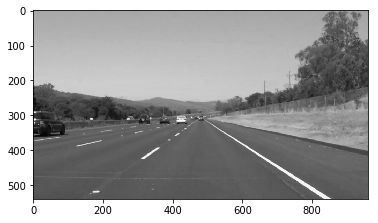

In [7]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')
img_gray = grayscale(img)
plt.imshow(img_gray, cmap='gray')

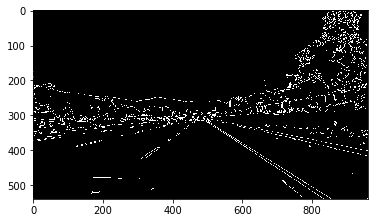

In [8]:
low_threshold = 50
high_threshold = 100
img_gray_canny = canny(img_gray, low_threshold, high_threshold)
plt.imshow(img_gray_canny, cmap='Greys_r')
plt.show()

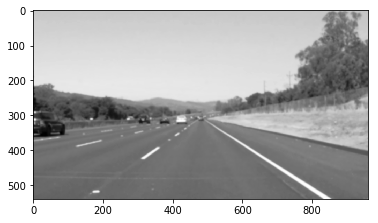

In [9]:
kernel_size = 9  # range from 3 to 9, small to biggest blur. a bigger blur acts as filter
img_gray_blur = gaussian_blur(img_gray, kernel_size)
plt.imshow(img_gray_blur, cmap='Greys_r')
plt.show()

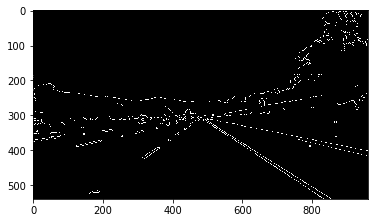

In [10]:
low_threshold = 45
high_threshold = 90
img_gray_blur_canny = canny(img_gray_blur, low_threshold, high_threshold)
plt.imshow(img_gray_blur_canny, cmap='Greys_r')
plt.show()

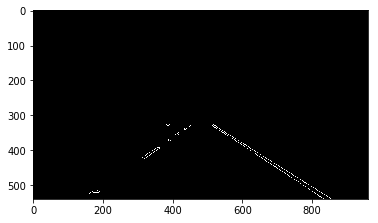

In [11]:
imshape = img.shape
v_max = imshape[0]
v_margin = 325
h_max = imshape[1]
h_margin_high = 380
h_margin_low = 50
vertices = np.array([[(h_margin_low, v_max), \
                      (h_margin_high, v_margin), 
                      (h_max - h_margin_high, v_margin), 
                      (h_max - h_margin_low, v_max)]], 
                    dtype=np.int32)
img_gray_blur_canny_mask = region_of_interest(img_gray_blur_canny, vertices)
plt.imshow(img_gray_blur_canny_mask, cmap='Greys_r')
plt.show()

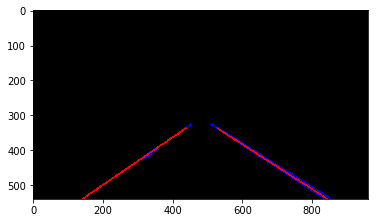

In [12]:
lines_hough = hough_lines(img_gray_blur_canny_mask)
plt.imshow(lines_hough, cmap='Greys_r')
plt.show()

In [13]:
def detect_lane(img, single_img = False):
    img_gray = grayscale(img)

    kernel_size = 9     # range from 3 to 9, small to biggest blur. a bigger blur acts as filter
    img_gray_blur = gaussian_blur(img_gray, kernel_size)

    low_threshold = 45
    high_threshold = 90
    img_gray_blur_canny = canny(img_gray_blur, low_threshold, high_threshold)

    imshape = img.shape
    v_max = imshape[0]
    v_margin = int(0.67 * imshape[0])
    h_max = imshape[1]
    h_margin_high = int(0.4 * imshape[1])
    h_margin_low = int(0.1 * imshape[1])
    vertices = np.array([[(h_margin_low, v_max), \
                          (h_margin_high, v_margin), 
                          (h_max - h_margin_high, v_margin), 
                          (h_max - h_margin_low, v_max)]], 
                        dtype=np.int32)
    img_gray_blur_canny_mask = region_of_interest(img_gray_blur_canny, vertices)

    #rho = 1 
    #theta = np.pi/180
    #threshold = 30        # minimum number of votes (intersections in Hough grid cell)
    #min_line_len = 10     # minimum number of pixels making up a line
    #max_line_gap = 10     # maximum gap in pixels between connectable line segments
    
    #lines_hough = hough_lines(img_gray_blur_canny_mask, rho, theta, threshold, min_line_len, max_line_gap)
    lines_hough = hough_lines(img_gray_blur_canny_mask, single_img)

    img_lane = weighted_img(lines_hough, img)
    return img_lane

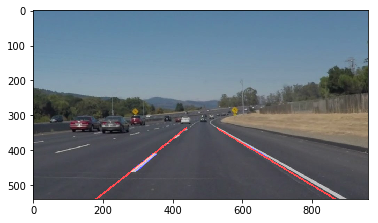

In [14]:
img = mpimg.imread('test_images/solidWhiteCurve.jpg')
single_img = True
out_img = detect_lane(img, single_img)
plt.imshow(out_img)

test_images/solidWhiteRight.jpg


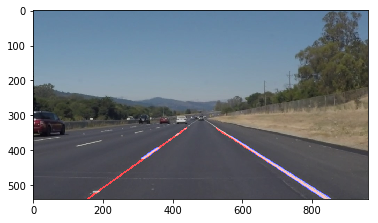

test_images/solidYellowCurve.jpg


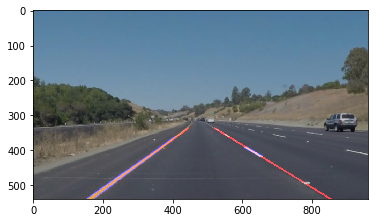

test_images/solidWhiteCurve.jpg


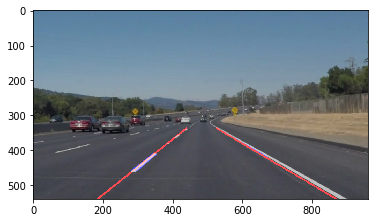

test_images/solidYellowCurve2.jpg


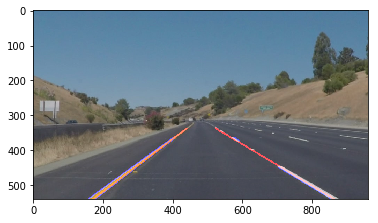

test_images/solidYellowLeft.jpg


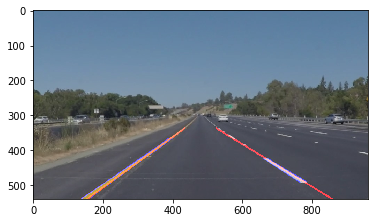

test_images/whiteCarLaneSwitch.jpg


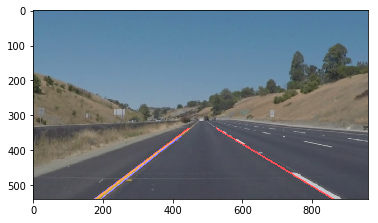

In [15]:
for input_img in os.listdir('test_images/'):
    print('test_images/' + input_img)
    img = mpimg.imread('test_images/' + input_img)
    single_img = True
    out_img = detect_lane(img, single_img)
    plt.imshow(out_img)
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    return detect_lane(image)

Let's try the one with the solid white lane on the right first ...

In [18]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 28.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.11 s, sys: 248 ms, total: 6.36 s
Wall time: 8.25 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Test case: Solid White Right
- **Test description**: Tests the detect_lane function for the case where the right lane is white and continuous, driving on a straight line.


- **Requirement 1**: The output video is an annotated version of the input video.
- **Acceptance criteria 1**: Does the pipeline for line identification take road images from a video as input and return an annotated video stream as output?
- **Test output 1**: **<font color='green'>PASS</font>**


- **Requirement 2**: In a rough sense, the left and right lane lines are accurately annotated throughout almost all of the video. Annotations can be segmented or solid lines
- **Acceptance criteria 2**: Has a pipeline been implemented that uses the helper functions and / or other code to roughly identify the left and right lane lines with either line segments or solid lines? (example solution included in the repository output: raw-lines-example.mp4)
- **Test output 2**: **<font color='green'>PASS</font>**


- **Requirement 3**: Visually, the left and right lane lines are accurately annotated by solid lines throughout most of the video.
- **Acceptance criteria 3**: Have detected line segments been filtered / averaged / extrapolated to map out the full extent of the left and right lane boundaries? (example solution included in the repository: P1_example.mp4)
- **Test output 3**: **<font color='green'>PASS</font>**


- **Observation**: An average operation for lane prediction between frames is enabled and applied only to the right lane. The difference is visible between the lane prediction on the left and write lanes.


**TAG_BUG**: At the end of the video, the hough transformation is not capturing the right lane and the predicted right lane is not updated. 


**TAG_WONT_FIX**: It is likely a paremeter issue at the Hough function. For the purposes of this project this outcome is fine IMO.

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [20]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:24<00:00, 27.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 19.6 s, sys: 640 ms, total: 20.2 s
Wall time: 25.4 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Test case: Solid Yellow Left
- **Test description**: Test the detect_lane function for the case where the left lane is yellow and continuous, driving on a straight line.


- **Requirement 1**: The output video is an annotated version of the input video.
- **Acceptance criteria 1**: Does the pipeline for line identification take road images from a video as input and return an annotated video stream as output?
- **Test output 1**: **<font color='green'>PASS</font>**


- **Requirement 2**: In a rough sense, the left and right lane lines are accurately annotated throughout almost all of the video. Annotations can be segmented or solid lines
- **Acceptance criteria 2**: Has a pipeline been implemented that uses the helper functions and / or other code to roughly identify the left and right lane lines with either line segments or solid lines? (example solution included in the repository output: raw-lines-example.mp4)
- **Test output 2**: **<font color='green'>PASS</font>**


- **Requirement 3**: Visually, the left and right lane lines are accurately annotated by solid lines throughout most of the video.
- **Acceptance criteria 3**: Have detected line segments been filtered / averaged / extrapolated to map out the full extent of the left and right lane boundaries? (example solution included in the repository: P1_example.mp4)
- **Test output 3**: **<font color='green'>PASS</font>**

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Algorithm analysis:
- Mask:
 - (+) The detect_lane function uses a vectorized window which adjusts to the input size. 
 - (!) It could only be tested on two test cases and the challenge. A wide variaty of scenarios would be required to test the efficiency from this fixed vectorized approach: Cars crossing the mask window, cars on the adjacent lanes, car itself switching lanes, etc.
- Lane identification
 - (+) For the given test cases, the lane identification works most of the time. Additional tweak on different parameters, like the ones for Hough algorithm, could improve the overall performance.
 - (-) It only extrapolate lines in a straight lane, curve lines also work but show a worse performance. See Challenge output.
 - (-) The filtering applied (slope threshold and mask) were not enough to filter out undesired lines. 
 - (-) Shadow changes and collor changes on the road exposed issues on the current filter and lane identification algorithm. See challenge output.
 - (+) An extrapolation in between frames to smooth transitions, such as the one applied on the right lane present a good posibility for improvement.
 
 - Conclusion: As an introductory project on the use of OpenCV for the task of lane identification, the produced output is fine. Additionally it presented an initial opportunity to work on image and video manipulation, which are key on following lessons and projects.   

- **Requirement 10**: Reflection describes the current pipeline, identifies its potential shortcomings and suggests possible improvements. There is no minimum length. Writing in English is preferred but you may use any language.
- **Acceptance criteria 10**: Has a thoughtful reflection on the project been provided in the notebook?
- **Test output 10**: **<font color='green'>PASS</font>**

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [22]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:16<00:00, 14.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 10.7 s, sys: 428 ms, total: 11.1 s
Wall time: 18.9 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### Test case: Challenge
- **Test description**: Test the detect_lane function for the case where the left lane is yellow and continuous, driving on a slight curve, with shadow and color changes on the road.


- **Requirement 1**: The output video is an annotated version of the input video.
- **Acceptance criteria 1**: Does the pipeline for line identification take road images from a video as input and return an annotated video stream as output?
- **Test output 1**: **<font color='green'>PASS</font>**


- **Requirement 2**: In a rough sense, the left and right lane lines are accurately annotated throughout almost all of the video. Annotations can be segmented or solid lines
- **Acceptance criteria 2**: Has a pipeline been implemented that uses the helper functions and / or other code to roughly identify the left and right lane lines with either line segments or solid lines? (example solution included in the repository output: raw-lines-example.mp4)
- **Test output 2**: **<font color='green'>PASS</font>**


- **Requirement 3**: Visually, the left and right lane lines are accurately annotated by solid lines throughout most of the video.
- **Acceptance criteria 3**: Have detected line segments been filtered / averaged / extrapolated to map out the full extent of the left and right lane boundaries? (example solution included in the repository: P1_example.mp4)
- **Test output 3**: **<font color='green'>PASS</font>**